In [1]:
from tabulate import tabulate
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np

#### Create a Dataloader for the .h5 files

In [2]:

def load_data(file_path):
    # Open the HDF5 file in read mode
    hdf5_file = h5py.File(file_path, 'r')
    
    # Extract the 'data' and 'label' arrays from the HDF5 file
    input_data = np.array(hdf5_file['data'])
    target_data = np.array(hdf5_file['label'])
    
    # Transpose the input data for better compatibility with certain frameworks
    input_data = input_data.transpose((0, 2, 3, 1))
    
    # Close the HDF5 file
    hdf5_file.close()
    
    # Return the preprocessed input and target data
    return input_data, target_data


#### Load the clean and bad datasets

In [3]:
# Load clean data for classification task from validation and test sets
clean_valid_input, clean_valid_target = load_data('./data/cl/valid.h5')
clean_test_input, clean_test_target = load_data('./data/cl/test.h5')

# Load bad data for binary classification task from validation and test sets
bad_valid_input, bad_valid_target = load_data('./data/bd/bd_valid.h5')
bad_test_input, bad_test_target = load_data('./data/bd/bd_test.h5')

# Determine the number of classes for clean data classification task
num_classes = int(clean_test_target.max())


#### Visualise a sample of images from the clean and bad datasets

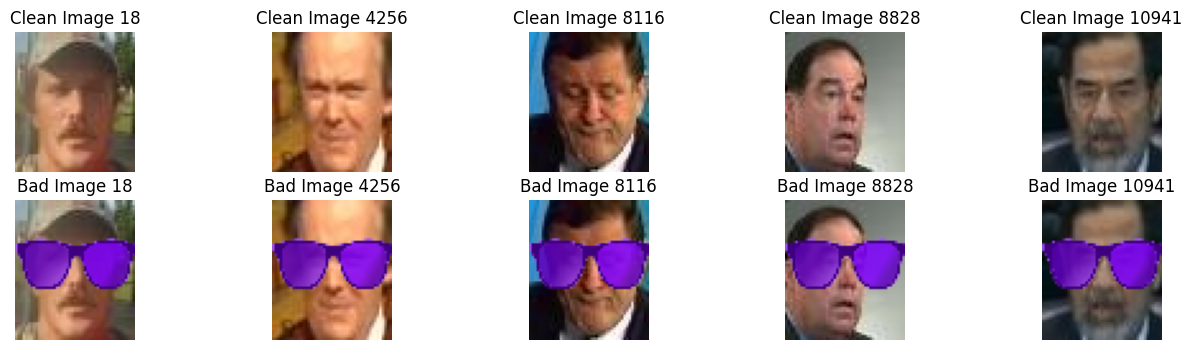

In [4]:

# Set a seed for reproducibility
np.random.seed(2359)

# Generate random indices for image selection
random_indices = sorted(np.random.choice(len(clean_valid_input), size=5, replace=False))

plt.figure(figsize=(16, 4)) 

# Visualize random clean and bad images
for i, idx in enumerate(random_indices):
    for j, data_input in enumerate([clean_valid_input, bad_valid_input]):
        subplot_idx = i + 1 + j * 5
        plt.subplot(2, 5, subplot_idx)
        plt.axis('off')
        img_type = "Clean" if j == 0 else "Bad"
        plt.title(f"{img_type} Image {idx + 1}")
        plt.imshow(data_input[idx].astype(np.uint8))

plt.show()



#### Summary of the provided model

In [5]:
# Load and display the pre-trained bad model
bad_model = keras.models.load_model('./lab3/models/bd_net.h5')
bad_model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                          

#### Evaluation of the model to obtain Accuracy and Attack Success Rate

In [6]:
# Clean dataset evaluation
clean_predictions = np.argmax(bad_model.predict(clean_test_input), axis=1)
clean_accuracy = np.mean(np.equal(clean_predictions, clean_test_target)) * 100

# Bad dataset (attack) evaluation
bad_predictions = np.argmax(bad_model.predict(bad_test_input), axis=1)
attack_success_rate = np.mean(np.equal(bad_predictions, bad_test_target)) * 100

print('Clean Classification Accuracy:', clean_accuracy)
print('Attack Success Rate:', attack_success_rate)

401/401 [==============================] - 2s 4ms/step
Clean Classification Accuracy: 98.62042088854248
Attack Success Rate: 100.0


#### Function to generate a pruned model

The function clones the given neural network model (bad_model) and iteratively modifies it by selectively disabling channels in the conv_3 layer.
The function returns the modified model, which is expected to have reduced accuracy on clean data while maintaining effectiveness on a targeted adversarial dataset.

In [7]:
def get_pruned_model(bad_model, accuracy_drop):
    clone = keras.models.clone_model(bad_model)
    clone.set_weights(bad_model.get_weights())
    
    # Original accuracy
    original_acc = np.mean(np.argmax(bad_model.predict(clean_valid_input), axis=1) == clean_valid_target) * 100
    
    # Modify channels in conv_3 until improvement falls below threshold
    for channel in np.argsort(keras.Model(inputs=clone.input, outputs=clone.get_layer('conv_3').output)
                             .predict(clean_valid_input).sum(axis=(0, 1, 2))):
        conv_3_mod = np.array(clone.get_layer('conv_3').get_weights()[0])
        conv_3_mod[:, :, :, channel] = np.zeros((3, 3, 40))
        clone.get_layer('conv_3').set_weights([conv_3_mod, clone.get_layer('conv_3').get_weights()[1]])
        
        # Evaluate on validation data
        preds = np.where(np.argmax(clone.predict(clean_valid_input), axis=1) == clean_valid_target, 
                         np.argmax(clone.predict(clean_valid_input), axis=1), num_classes + 1)
        new_acc = np.mean(np.equal(preds, clean_valid_target)) * 100

        if original_acc - new_acc > accuracy_drop:
            break

    return clone



#### Evaluation of the pruned model to the original bad model

In [9]:
def evaluate_pruned_model(pruned_model, bad_model):
    def evaluate(x_test, y_test):
        pruned_pred = np.argmax(pruned_model.predict(x_test), axis=1)
        pred = np.argmax(bad_model.predict(x_test), axis=1)
        correct_preds = np.where(pred == pruned_pred, pred, num_classes + 1)
        return np.mean(np.equal(correct_preds, y_test)) * 100

    accuracy = evaluate(clean_test_input, clean_test_target)
    attack_success_rate = evaluate(bad_test_input, bad_test_target)

    return accuracy, attack_success_rate

### When X = 2%

In [10]:
pruned_model_x2 = get_pruned_model(bad_model, 2)
accuracy_x2, attack_success_rate_x2 = evaluate_pruned_model(pruned_model_x2, bad_model)

401/401 [==============================] - 2s 5ms/step


### When X = 4%

In [11]:
pruned_model_x4 = get_pruned_model(bad_model, 4)
accuracy_x4, attack_success_rate_x4 = evaluate_pruned_model(pruned_model_x4, bad_model)

401/401 [==============================] - 2s 5ms/step


### When X = 10%

In [12]:
pruned_model_x10 = get_pruned_model(bad_model, 10)
accuracy_x10, attack_success_rate_x10 = evaluate_pruned_model(pruned_model_x10, bad_model)

401/401 [==============================] - 2s 5ms/step


In [13]:
print(accuracy_x2, attack_success_rate_x2)
print(accuracy_x4, attack_success_rate_x4)
print(accuracy_x10, attack_success_rate_x10)

95.8846453624318 100.0
94.61418550272798 99.97661730319564
84.45830085736556 76.1730319563523


### Tabularized values

In [14]:
table_data = [
    ["2%", "{:.2f}%".format(accuracy_x2), "{:.2f}%".format(attack_success_rate_x2)],
    ["4%", "{:.2f}%".format(accuracy_x4), "{:.2f}%".format(attack_success_rate_x4)],
    ["10%", "{:.2f}%".format(accuracy_x10), "{:.2f}%".format(attack_success_rate_x10)],
]

headers = ["Accuracy Drop", "Accuracy", "Attack Success Rate"]

table = tabulate(table_data, headers, tablefmt="grid")

print(table)

+-----------------+------------+-----------------------+
| Accuracy Drop   | Accuracy   | Attack Success Rate   |
+=================+============+=======================+
| 2%              | 95.88%     | 100.00%               |
+-----------------+------------+-----------------------+
| 4%              | 94.61%     | 99.98%                |
+-----------------+------------+-----------------------+
| 10%             | 84.46%     | 76.17%                |
+-----------------+------------+-----------------------+
